In [1044]:
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import rough_path_signatures_pricing.signature_regressor as sr
import rough_path_signatures_pricing.simulation_models as sm

importlib.reload(sm)
importlib.reload(sr)

<module 'rough_path_signatures_pricing.signature_regressor' from 'C:\\Users\\chris\\VSCodeProjects\\rough-path-signatures-pricing\\src\\rough_path_signatures_pricing\\signature_regressor.py'>

In [1045]:
PROJECT_DIR = Path.cwd().parent / "data"
DATA_PATH = PROJECT_DIR / "spx_call_put_100strikes.csv"

#### GBM Paths for Fitting Linear Functional with Signature to Approximate Payoffs

Create a generator object

In [1046]:
gbm_params = {
    "x0": 6500,
    "t0": 0,
    "t1": 1,
    "n_steps": 252,
    "seed": 42,
    "mu": 0,
    "sigma": 0.4,
}
gbm_simulator = sm.GBM(**gbm_params)

Pricing functions

In [1047]:
def barrier_up_out_call_payoff(
    path: np.ndarray, strike: float, barrier: float
) -> float:
    """
    Compute the payoff of an up-and-out barrier call option.

    Parameters
    ----------
    path : np.ndarray
        A single simulated price path (1D array)
    strike : float
        Strike price of the call option
    barrier : float
        Barrier level (if price goes above this, option is knocked out)

    Returns
    -------
    float
        Payoff of the barrier call option
    """
    max_price = np.max(path)
    final_price = path[-1]

    if max_price > barrier:
        return 0.0

    # Otherwise, standard call option payoff at maturity
    return max(final_price - strike, 0.0)


def barrier_up_in_call_payoff(path: np.ndarray, strike: float, barrier: float) -> float:
    """
    Compute the payoff of an up-and-in barrier call option.

    Parameters
    ----------
    path : np.ndarray
        A single simulated price path (1D array)
    strike : float
        Strike price of the call option
    barrier : float
        Barrier level (price must hit this to activate the option)

    Returns
    -------
    float
        Payoff of the barrier call option
    """
    max_price = np.max(path)
    final_price = path[-1]

    # If the price NEVER reached the barrier, the option is worthless
    if max_price < barrier:
        return 0.0

    # If it DID hit the barrier, it behaves like a standard call option
    return max(final_price - strike, 0.0)


def asian_fixed_strike_call_payoff(path: np.ndarray, strike: float) -> float:
    """
    Compute the payoff of a fixed-strike Asian call option.

    Payoff = max(Average_Price - Strike, 0)
    """

    # Calculate the arithmetic average price
    average_price = np.mean(path, axis=1)

    # Standard call payoff logic using the average
    return np.maximum(average_price - strike, 0.0)


def asian_fixed_strike_put_payoff(path: np.ndarray, strike: float) -> float:
    """
    Compute the payoff of a fixed-strike Asian put option.

    Parameters
    ----------
    path : np.ndarray
        A single simulated price path.
    strike : float
        The pre-determined strike price.

    Returns
    -------
    float
        Payoff = max(Strike - Average_Price, 0)
    """

    # 2. Calculate the arithmetic average price over that period
    average_price = np.mean(path, axis=1)

    # 3. Put payoff logic: profit if average is below strike
    return np.maximum(strike - average_price, 0.0)


def fixed_strike_call_payoff(path: np.ndarray, strike: float) -> float:
    """
    Compute the payoff of a fixed-strike put option.

    Parameters
    ----------
    path : np.ndarray
        A single simulated price path.
    strike : float
        The pre-determined strike price.

    Returns
    -------
    float
        Payoff = max(Final_Price - Strike, 0)
    """

    # 2. Calculate the arithmetic average price over that period
    final_price = path[:, -1]

    # 3. Put payoff logic: profit if average is below strike
    return np.maximum(final_price - strike, 0.0)


def fixed_strike_put_payoff(path: np.ndarray, strike: float) -> float:
    """
    Compute the payoff of a fixed-strike put option.

    Parameters
    ----------
    path : np.ndarray
        A single simulated price path.
    strike : float
        The pre-determined strike price.

    Returns
    -------
    float
        Payoff = max(Final_Price - Strike, 0)
    """

    # 2. Calculate the arithmetic average price over that period
    final_price = path[:, -1]

    # 3. Put payoff logic: profit if average is below strike
    return np.maximum(strike - final_price, 0.0)

Creating the pricer object

In [ ]:
N = 5
N_PATHS = 1000
LAM = 0  # Lambda for ridge regression
FUNC = fixed_strike_call_payoff

FRAC = 0.7
SPLIT_SEED = 42

In [1049]:
gbm_signature_pricer = sr.SignaturePricer(
    simulator=gbm_simulator, func=FUNC, signature_degree=N
)


In [1050]:
# df = pd.read_csv(DATA_PATH)
# calls = df[df["Type"] == "Asian_Call"].sort_values("Strike")
# puts = df[df["Type"] == "Asian_Put"].sort_values("Strike")

# strikes = calls["Strike"].values
# call_prices = calls["Price"].values
# put_prices = puts["Price"].values

# if np.array_equal(strikes, puts["Strike"].values):
#     print("Strikes match perfectly for both calls and puts.")
#     print(f"Number of data points: {len(strikes)}")
# else:
#     print("Warning: Strikes do not match between calls and puts.")

Read market prices

In [1051]:
df = pd.read_csv(DATA_PATH)
df_call = df[df.columns[:7]]
df_call.columns

calls = df_call.sample(frac=FRAC, random_state=SPLIT_SEED)
strikes = calls["Strike"].values
call_prices = calls["Ask"].values

In [1052]:
PRICE = call_prices
STRIKES = strikes

Fit the object to observed prices

In [1053]:
gbm_signature_pricer.fit(X=STRIKES, y=PRICE, n_paths=N_PATHS, lam=LAM)

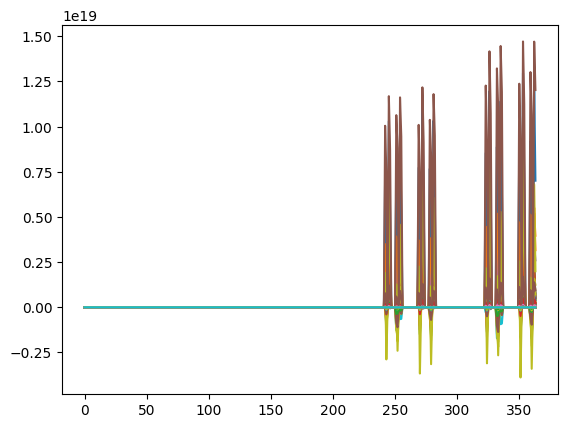

In [1054]:
plt.figure()
plt.plot(gbm_signature_pricer.signatures_.T)
plt.show()

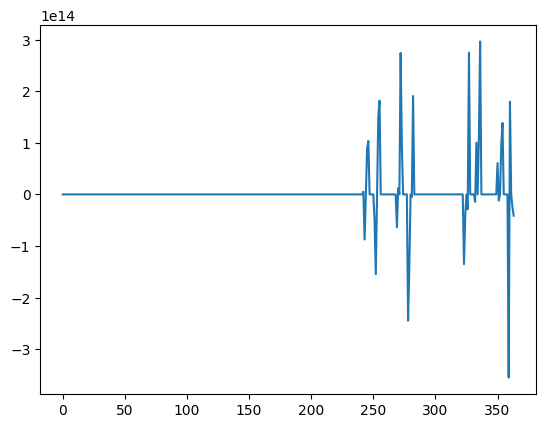

In [1055]:
plt.figure()
plt.plot(gbm_signature_pricer.implied_expected_signature_)
plt.show()

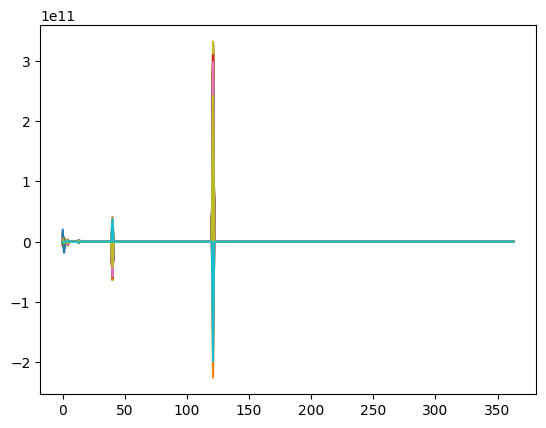

In [1056]:
plt.figure()
plt.plot(gbm_signature_pricer.coeffs_.T)
plt.show()

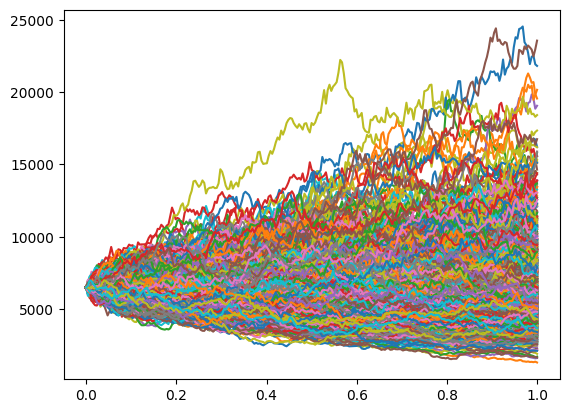

In [1057]:
plt.figure()
plt.plot(gbm_signature_pricer.times_, gbm_signature_pricer.paths_.T)
plt.show()

Predict price on desired option with given parameter

In [1058]:
call_test = df_call.drop(calls.index)

price = gbm_signature_pricer.predict(X=call_test["Strike"].values)

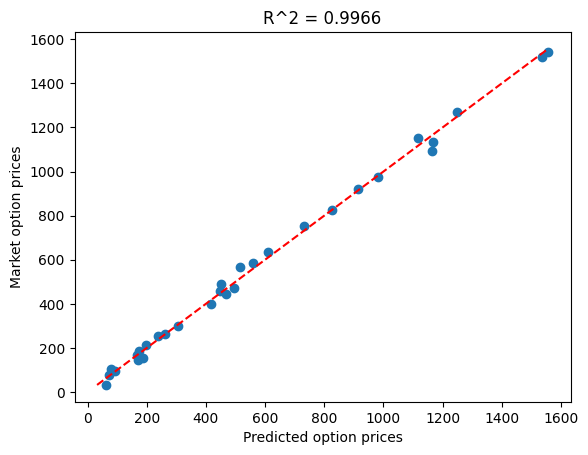

In [1059]:
y_true = call_test["Ask"].values
y_pred = price

# Compute R^2
ss_res = np.sum((y_true - y_pred) ** 2)
ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
r2 = 1 - (ss_res / ss_tot)

plt.figure()
plt.scatter(y_pred, y_true)

# Add identity line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Perfect Fit")

plt.xlabel("Predicted option prices")
plt.ylabel("Market option prices")
plt.title(f"R^2 = {r2:.4f}")
plt.show()